# Airbnb Project

## Import Needed Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf
import operator
from math import hypot
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

## Data Cleaning

#### Data Cleaning formulas we will use


In [2]:
properties = ['Apartment', 'House', 'Condomminium', 'Townhouse', 'Loft', 'Other']
def property_grouping(p):
    '''
    Given property type, if it is not an apartment, house, condo, townhouse, loft, or
    labeled as 'Other', set as 'Other'
    '''
    if p not in properties:
        p = 'Other'
    return p

def make_dummies(df):
    '''
    Take column of categories and make dummies in the dataset.
    Drop the original columns
    '''
    columns = list(df.columns)
    for column in columns:
        dummies = pd.get_dummies(df[column])
        df = df.join(dummies)
    df.columns = df.columns.str.replace(' ', '_')
    df.columns = df.columns.str.replace('/','_')
    df.columns = df.columns.str.replace('-', '_')
    df.drop(columns=columns,inplace=True)
    return df

#### Calculating Distance
There are 6 cities in the dataset. We are setting the coordinates for the downtown of each city.
Then we calculate the distance of each Airbnb from downtown.

In [3]:
lat_long = {'SF': {'lat': 37.7749, 'long': -122.4194},
            'Chicago': {'lat': 41.8781, 'long': -87.6298},
            'DC': {'lat': 38.9072, 'long': -77.0369},
            'LA': {'lat': 34.0522, 'long': -118.2437},
            'Boston': {'lat': 42.3601, 'long': -71.0589},
            'NYC': {'lat': 40.7128, 'long': -74.0060}}

def get_distance(row):
    '''
    Given a row of data, get the city, latitude, and longitude
    and calculate the distance from downtown.
    '''
    city = row['city']
    lat1 = lat_long[city]['lat']
    lat2 = row['latitude']
    long1 = lat_long[city]['long']
    long2 = row['longitude']
    lon = long1 - long2
    lat = lat1 - lat2
    a = (np.sin(lat/2))**2 + np.cos(lat1) * np.cos(lat2) * ((np.sin(lon/2))**2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return 69.172*c

#### Cleaning up

In [4]:
#import data as dataframe
df = pd.read_csv('train.csv')

In [5]:
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [6]:
#drop duplicates for Airbnb ID's and drop NA in specific columns
df.drop_duplicates(subset=['id'],inplace=True)
df.dropna(subset=['bathrooms', 'host_has_profile_pic',
                  'host_identity_verified', 'host_since',
                  'bedrooms', 'beds'],
                   inplace=True)

#create our distance column
df['distance'] = df.apply(lambda r: get_distance(r), axis=1)

#convert host response rates and review scores to floats between 0 and 1
df['host_response_rate'] = df['host_response_rate'].str.strip('%').astype('float')/100
df.review_scores_rating = df.review_scores_rating/100

#fill in empty host response rates and review scores as 0
df['host_response_rate'].fillna(value=0.0, inplace=True)
df['review_scores_rating'].fillna(value=0.0, inplace=True)

#Replace t,f and True,False to 1 and 0
df.replace({'t':1, 'f': 0}, inplace=True)
df.cleaning_fee = df.cleaning_fee.astype(int)

#Apply a sqrt transform on number_of_reviews
df.number_of_reviews = df.number_of_reviews.apply(lambda x: np.sqrt(x))

In [7]:
#make a new columns of accommodates per bedroom
df['ppl_per_room'] = df['accommodates'] / df['bedrooms']

#replace inf and -inf with 0.0
df.ppl_per_room = df.ppl_per_room.replace([np.inf, -np.inf], float(0.0))

In [8]:
#Drop unwanted columns
df_cleaned = df.drop(columns = ['id','amenities', 'description',
                               'first_review', 'host_since', 'last_review',
                               'name', 'neighbourhood', 'thumbnail_url',
                               'zipcode', 'city', 'latitude', 'longitude', 'beds'])

In [9]:
#apply property_grouping function to property_type
df_cleaned['property_type'] = df_cleaned['property_type'].apply(property_grouping)

#get rid of any super strict policies since there are relatively a few of them
df_cleaned = df_cleaned[df_cleaned['cancellation_policy'].str.contains('super')==False]

In [10]:
df_cleaned.head()

,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,number_of_reviews,review_scores_rating,bedrooms,distance,ppl_per_room
0,5.010635,Apartment,Entire home/apt,3,1.0,Real Bed,strict,1,1,1,0.0,0,1.414214,1.00,1.0,1.496396,3.000000
1,5.129899,Apartment,Entire home/apt,7,1.0,Real Bed,strict,1,1,0,1.0,1,2.449490,0.93,3.0,3.868174,2.333333
2,4.976734,Apartment,Entire home/apt,5,1.0,Real Bed,moderate,1,1,1,1.0,1,3.162278,0.92,1.0,7.865697,5.000000
3,6.620073,House,Entire home/apt,4,1.0,Real Bed,flexible,1,1,1,0.0,0,0.000000,0.00,2.0,0.866327,2.000000
4,4.744932,Apartment,Entire home/apt,2,1.0,Real Bed,moderate,1,1,1,1.0,1,2.000000,0.40,0.0,1.275820,0.000000


In [11]:
#Rearranging the dataframe
B = df_cleaned.select_dtypes(exclude='object')
A = df_cleaned[['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified','instant_bookable']]
B = B.drop(columns=list(A.columns))
C = df_cleaned.select_dtypes(include='object')

In [12]:
final_df = A.join(C)
final_df = final_df.join(B)

In [13]:
final_df.head()

,cleaning_fee,host_has_profile_pic,host_identity_verified,instant_bookable,property_type,room_type,bed_type,cancellation_policy,log_price,accommodates,bathrooms,host_response_rate,number_of_reviews,review_scores_rating,bedrooms,distance,ppl_per_room
0,1,1,1,0,Apartment,Entire home/apt,Real Bed,strict,5.010635,3,1.0,0.0,1.414214,1.00,1.0,1.496396,3.000000
1,1,1,0,1,Apartment,Entire home/apt,Real Bed,strict,5.129899,7,1.0,1.0,2.449490,0.93,3.0,3.868174,2.333333
2,1,1,1,1,Apartment,Entire home/apt,Real Bed,moderate,4.976734,5,1.0,1.0,3.162278,0.92,1.0,7.865697,5.000000
3,1,1,1,0,House,Entire home/apt,Real Bed,flexible,6.620073,4,1.0,0.0,0.000000,0.00,2.0,0.866327,2.000000
4,1,1,1,1,Apartment,Entire home/apt,Real Bed,moderate,4.744932,2,1.0,1.0,2.000000,0.40,0.0,1.275820,0.000000


In [14]:
dummies = make_dummies(final_df.iloc[:,4:8])
final_df = final_df.join(dummies)
final_df.drop(columns=['property_type', 'room_type', 'bed_type', 'cancellation_policy'], inplace=True)

In [15]:
final_df.head()

,cleaning_fee,host_has_profile_pic,host_identity_verified,instant_bookable,log_price,accommodates,bathrooms,host_response_rate,number_of_reviews,review_scores_rating,bedrooms,distance,ppl_per_room,Apartment,House,Loft,Other,Townhouse,Entire_home_apt,Private_room,Shared_room,Airbed,Couch,Futon,Pull_out_Sofa,Real_Bed,flexible,moderate,strict
0,1,1,1,0,5.010635,3,1.0,0.0,1.414214,1.00,1.0,1.496396,3.000000,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
1,1,1,0,1,5.129899,7,1.0,1.0,2.449490,0.93,3.0,3.868174,2.333333,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
2,1,1,1,1,4.976734,5,1.0,1.0,3.162278,0.92,1.0,7.865697,5.000000,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
3,1,1,1,0,6.620073,4,1.0,0.0,0.000000,0.00,2.0,0.866327,2.000000,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0
4,1,1,1,1,4.744932,2,1.0,1.0,2.000000,0.40,0.0,1.275820,0.000000,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0


In [16]:
y = final_df.log_price
final_df.drop(columns='log_price',inplace=True)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(final_df, y, test_size=.3)

# Analysis

In [18]:
final_df.head()

,cleaning_fee,host_has_profile_pic,host_identity_verified,instant_bookable,accommodates,bathrooms,host_response_rate,number_of_reviews,review_scores_rating,bedrooms,distance,ppl_per_room,Apartment,House,Loft,Other,Townhouse,Entire_home_apt,Private_room,Shared_room,Airbed,Couch,Futon,Pull_out_Sofa,Real_Bed,flexible,moderate,strict
0,1,1,1,0,3,1.0,0.0,1.414214,1.00,1.0,1.496396,3.000000,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
1,1,1,0,1,7,1.0,1.0,2.449490,0.93,3.0,3.868174,2.333333,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
2,1,1,1,1,5,1.0,1.0,3.162278,0.92,1.0,7.865697,5.000000,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
3,1,1,1,0,4,1.0,0.0,0.000000,0.00,2.0,0.866327,2.000000,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0
4,1,1,1,1,2,1.0,1.0,2.000000,0.40,0.0,1.275820,0.000000,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0


In [19]:
X_numeric_train = X_train.iloc[:,4:12]
X_categorical_train = X_train.iloc[:,12:]
X_extra_train = X_train.iloc[:,:4]

In [20]:
ss = StandardScaler()

X_num_train_col = X_numeric_train.columns
X_num_train_ind = X_numeric_train.index

X_numeric_train = pd.DataFrame(ss.fit_transform(X_numeric_train))

X_numeric_train.columns = X_num_train_col
X_numeric_train.index = X_num_train_ind

In [21]:
X_numeric_train = X_numeric_train[(np.abs(X_numeric_train) < 2.5).all(axis=1)]

X_categorical_train = X_categorical_train[X_categorical_train.index.isin(X_numeric_train.index)]
X_extra_train = X_extra_train[X_extra_train.index.isin(X_numeric_train.index)]
y_train = y_train[y_train.index.isin(X_numeric_train.index)]

In [22]:
X1 = X_numeric_train.join(X_categorical_train)
X1 = X1.join(X_extra_train)

### Baseline
Getting rid of the dummy trap by setting our baseline as having an entire Apartment with a real bed and moderate rule policies.

In [23]:
X1.drop(columns=['Apartment', 'Entire_home_apt', 'Real_Bed', 'moderate'],inplace=True)
lr = LinearRegression()
lr.fit(X1,y_train)
lr.score(X1,y_train)

0.5024132936685557

In [24]:
X1.head()

,accommodates,bathrooms,host_response_rate,number_of_reviews,review_scores_rating,bedrooms,distance,ppl_per_room,House,Loft,Other,Townhouse,Private_room,Shared_room,Airbed,Couch,Futon,Pull_out_Sofa,flexible,strict,cleaning_fee,host_has_profile_pic,host_identity_verified,instant_bookable
19111,-0.539723,2.195668,0.668629,-0.706607,0.678126,-0.309226,0.370674,-0.092825,0,0,0,0,1,0,0,0,0,0,1,0,1,1,1,1
21091,-0.539723,-0.404743,-1.656534,-1.018634,-1.832619,-0.309226,-0.849672,-0.092825,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0
67058,-0.539723,-0.404743,0.668629,-0.478188,0.502374,-0.309226,-0.399002,-0.092825,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0
4828,-0.071715,-0.404743,0.668629,-0.478188,0.502374,-0.309226,-0.851121,0.725462,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0
7186,-0.539723,-0.404743,0.668629,1.231424,0.602804,-0.309226,-0.089172,-0.092825,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0


# Test Data

In [25]:
X_numeric_test = X_test.iloc[:,7:12]
X_categorical_test = X_test.iloc[:,12:]
X_extra_test = X_test.iloc[:,:3]

ss = StandardScaler()

X_num_test_col = X_numeric_test.columns
X_num_test_ind = X_numeric_test.index

X_numeric_test = pd.DataFrame(ss.fit_transform(X_numeric_test))

X_numeric_test.columns = X_num_test_col
X_numeric_test.index = X_num_test_ind

X_numeric_test = X_numeric_test[(np.abs(X_numeric_test) < 2.5).all(axis=1)]

X_categorical_test = X_categorical_test[X_categorical_test.index.isin(X_numeric_test.index)]
X_extra_test = X_extra_test[X_extra_test.index.isin(X_numeric_test.index)]
y_test = y_test[y_test.index.isin(X_numeric_test.index)]

X2 = X_numeric_test.join(X_categorical_test)
X2 = X2.join(X_extra_test)

X2.drop(columns=['Apartment', 'Entire_home_apt', 'Real_Bed', 'moderate'],inplace=True)

### R<sup>2</sup> Value

In [26]:
lr = LinearRegression()
lr.fit(X2,y_test)
lr.score(X2,y_test)

0.48551446869258164

#### Train Data Model

In [27]:
f1 = 'log_price ~ ' + '+'.join(X1.columns)
mod = smf.ols(formula=f1, data = X1.join(y_train))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     1925.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        17:08:17   Log-Likelihood:                -30303.
No. Observations:               45776   AIC:                         6.066e+04
Df Residuals:                   45751   BIC:                         6.087e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5.1239      0.041    124.520      0.000       5.043       5.205
accommodates               0.2002      0.005     36.524      0.000       0.189       0.211
bathrooms                  0.0860      0.004     21.500      0.000       0.078       0.094
host_response_rate        -0.0300      0.003    -11.840      0.000      -0.035      -0.025
number_of_reviews         -0.0193      0.003     -5.774      0.000      -0.026      -0.013
review_scores_rating      -0.0581      0.003    -21.030      0.000      -0.063      -0.053
bedrooms                   0.0931      0.004     23.203      0.000       0.085       0.101
distance                  -0.1398      0.003    -47.438      0.000      -0.146      -0.134
ppl_per_room              -0.0076      0.003     -2.518      0.012      -0.014      -0.002
House                      0.0156      0.006      2.569      0.010       0.004       0.027
Loft                       0.1349      0.017      7.953      0.000       0.102       0.168
Other                      0.1280      0.009     14.779      0.000       0.111       0.145
Townhouse                  0.0151      0.016      0.969      0.332      -0.015       0.046
Private_room              -0.5584      0.006    -96.851      0.000      -0.570      -0.547
Shared_room               -0.9768      0.014    -67.597      0.000      -1.005      -0.949
Airbed                    -0.0685      0.027     -2.496      0.013      -0.122      -0.015
Couch                      0.0108      0.036      0.298      0.765      -0.060       0.082
Futon                     -0.0661      0.022     -2.991      0.003      -0.109      -0.023
Pull_out_Sofa              0.0229      0.024      0.941      0.347      -0.025       0.071
flexible                   0.0038      0.006      0.598      0.550      -0.009       0.016
strict                     0.0326      0.006      5.916      0.000       0.022       0.043
cleaning_fee              -0.0264      0.006     -4.794      0.000      -0.037      -0.016
host_has_profile_pic      -0.0800      0.041     -1.963      0.050      -0.160      -0.000
host_identity_verified    -0.0059      0.005     -1.211      0.226      -0.015       0.004
instant_bookable          -0.0545      0.005    -10.589      0.000      -0.065      -0.044
==============================================================================
Omnibus:                     4057.378   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11616.865
Skew:                           0.487   Prob(JB):                         0.00
Kurtosis:                       5.268   Cond. No.                         50.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance mat

#### Test Data Model

In [28]:
f2 = 'log_price ~ ' + '+'.join(X2.columns)
mod = smf.ols(formula=f2, data = X2.join(y_test))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     941.7
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        17:08:17   Log-Likelihood:                -14154.
No. Observations:               19978   AIC:                         2.835e+04
Df Residuals:                   19957   BIC:                         2.852e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5.2105      0.061     85.399      0.000       5.091       5.330
number_of_reviews         -0.0245      0.005     -4.751      0.000      -0.035      -0.014
review_scores_rating      -0.0699      0.004    -16.065      0.000      -0.078      -0.061
bedrooms                   0.2329      0.005     46.802      0.000       0.223       0.243
distance                  -0.1372      0.005    -29.394      0.000      -0.146      -0.128
ppl_per_room               0.0261      0.004      5.974      0.000       0.018       0.035
House                      0.0475      0.009      5.015      0.000       0.029       0.066
Loft                       0.2194      0.028      7.771      0.000       0.164       0.275
Other                      0.1269      0.013      9.405      0.000       0.100       0.153
Townhouse                  0.0866      0.024      3.657      0.000       0.040       0.133
Private_room              -0.6897      0.008    -89.933      0.000      -0.705      -0.675
Shared_room               -1.1751      0.022    -53.889      0.000      -1.218      -1.132
Airbed                     0.0195      0.041      0.470      0.639      -0.062       0.101
Couch                      0.2257      0.058      3.874      0.000       0.112       0.340
Futon                     -0.0391      0.033     -1.179      0.238      -0.104       0.026
Pull_out_Sofa              0.0490      0.039      1.271      0.204      -0.027       0.124
flexible                   0.0145      0.010      1.463      0.143      -0.005       0.034
strict                     0.0613      0.009      7.047      0.000       0.044       0.078
cleaning_fee              -0.0251      0.009     -2.893      0.004      -0.042      -0.008
host_has_profile_pic      -0.1642      0.060     -2.720      0.007      -0.283      -0.046
host_identity_verified     0.0003      0.008      0.037      0.971      -0.015       0.015
==============================================================================
Omnibus:                     1985.296   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4886.473
Skew:                           0.590   Prob(JB):                         0.00
Kurtosis:                       5.117   Cond. No.                         46.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Final Model

In [29]:
X_numeric = final_df.iloc[:,7:12]
X_categorical = final_df.iloc[:,12:]
X_extra = final_df.iloc[:,:3]

ss = StandardScaler()

X_num_col = X_numeric.columns
X_num_ind = X_numeric.index

X_numeric = pd.DataFrame(ss.fit_transform(X_numeric))

X_numeric.columns = X_num_col
X_numeric.index = X_num_ind

X_numeric = X_numeric[(np.abs(X_numeric) < 2.5).all(axis=1)]

X_categorical = X_categorical[X_categorical.index.isin(X_numeric.index)]
X_extra = X_extra[X_extra.index.isin(X_numeric.index)]
y = y[y.index.isin(X_numeric.index)]

X = X_numeric.join(X_categorical)
X = X.join(X_extra)

X.drop(columns=['Apartment', 'Entire_home_apt', 'Real_Bed', 'moderate'],inplace=True)

lr = LinearRegression()
lr.fit(X,y)
lr.score(X,y)

0.48681462259074426

In [30]:
coefficients = dict(zip(X.columns,lr.coef_))
coefficients = sorted(coefficients.items(), key=(lambda c:c[1]), reverse=True)

In [31]:
coefficients

[('bedrooms', 0.22597559841884554),
 ('Loft', 0.19374508177132826),
 ('Other', 0.13652105561750896),
 ('Couch', 0.07814374173624752),
 ('Townhouse', 0.06297501732579289),
 ('House', 0.050780797171820595),
 ('strict', 0.047254407387032106),
 ('Pull_out_Sofa', 0.03895064476592418),
 ('ppl_per_room', 0.02798023614099318),
 ('flexible', 0.009102262278519168),
 ('host_identity_verified', -0.000983666291894836),
 ('cleaning_fee', -0.024500467131731922),
 ('Airbed', -0.02539493447627309),
 ('number_of_reviews', -0.02623115596122746),
 ('Futon', -0.057478508840145826),
 ('review_scores_rating', -0.06793409019954454),
 ('host_has_profile_pic', -0.1320903159892233),
 ('distance', -0.13726399458251914),
 ('Private_room', -0.6936695144085051),
 ('Shared_room', -1.1647015064028865)]

In [32]:
X.head()

,number_of_reviews,review_scores_rating,bedrooms,distance,ppl_per_room,House,Loft,Other,Townhouse,Private_room,Shared_room,Airbed,Couch,Futon,Pull_out_Sofa,flexible,strict,cleaning_fee,host_has_profile_pic,host_identity_verified
0,-0.576975,0.679538,-0.312032,-0.838453,0.717931,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
1,-0.253838,0.504135,2.033720,-0.410831,0.175259,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0
2,-0.031359,0.479077,-0.312032,0.309904,2.345947,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
3,-1.018387,-1.826225,0.860844,-0.952051,-0.096077,1,0,0,0,0,0,0,0,0,0,1,0,1,1,1
4,-0.394135,-0.823919,-1.484908,-0.878221,-1.724093,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1


In [33]:
X.drop(columns=['Airbed', 'Pull_out_Sofa', 'flexible', 'host_identity_verified'],inplace=True)
f = 'log_price ~ ' + '+'.join(X.columns)
mod = smf.ols(formula=f, data = X.join(y))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     3956.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        17:08:18   Log-Likelihood:                -46962.
No. Observations:               66760   AIC:                         9.396e+04
Df Residuals:                   66743   BIC:                         9.411e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                5.1922      0.034    150.821      0.000       5.125       5.260
number_of_reviews       -0.0268      0.003     -9.715      0.000      -0.032      -0.021
review_scores_rating    -0.0684      0.002    -29.323      0.000      -0.073      -0.064
bedrooms                 0.2259      0.003     84.537      0.000       0.221       0.231
distance                -0.1372      0.003    -54.204      0.000      -0.142      -0.132
ppl_per_room             0.0278      0.002     11.923      0.000       0.023       0.032
House                    0.0508      0.005      9.877      0.000       0.041       0.061
Loft                     0.1936      0.015     13.094      0.000       0.165       0.223
Other                    0.1364      0.007     18.506      0.000       0.122       0.151
Townhouse                0.0628      0.013      4.810      0.000       0.037       0.088
Private_room            -0.6935      0.004   -166.911      0.000      -0.702      -0.685
Shared_room             -1.1634      0.012    -98.731      0.000      -1.186      -1.140
Couch                    0.0779      0.032      2.468      0.014       0.016       0.140
Futon                   -0.0581      0.019     -3.086      0.002      -0.095      -0.021
strict                   0.0429      0.004     10.646      0.000       0.035       0.051
cleaning_fee            -0.0261      0.005     -5.655      0.000      -0.035      -0.017
host_has_profile_pic    -0.1332      0.034     -3.887      0.000      -0.200      -0.066
==============================================================================
Omnibus:                     6265.145   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16423.742
Skew:                           0.542   Prob(JB):                         0.00
Kurtosis:                       5.174   Cond. No.                         44.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Visualizations

In [34]:
final_df
actual_prices = y.apply(lambda Y: np.exp(Y))
actual_prices

0        150.0
1        169.0
2        145.0
3        750.0
4        115.0
         ...  
74105     70.0
74106    100.0
74107    155.0
74108    185.0
74109    195.0
Name: log_price, Length: 66760, dtype: float64

In [35]:
df_vis = final_df.join(actual_prices)

In [36]:
df_vis

,cleaning_fee,host_has_profile_pic,host_identity_verified,instant_bookable,accommodates,bathrooms,host_response_rate,number_of_reviews,review_scores_rating,bedrooms,distance,ppl_per_room,Apartment,House,Loft,Other,Townhouse,Entire_home_apt,Private_room,Shared_room,Airbed,Couch,Futon,Pull_out_Sofa,Real_Bed,flexible,moderate,strict,log_price
0,1,1,1,0,3,1.0,0.0,1.414214,1.00,1.0,1.496396,3.000000,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,150.0
1,1,1,0,1,7,1.0,1.0,2.449490,0.93,3.0,3.868174,2.333333,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,169.0
2,1,1,1,1,5,1.0,1.0,3.162278,0.92,1.0,7.865697,5.000000,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,145.0
3,1,1,1,0,4,1.0,0.0,0.000000,0.00,2.0,0.866327,2.000000,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,750.0
4,1,1,1,1,2,1.0,1.0,2.000000,0.40,0.0,1.275820,0.000000,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,115.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74106,0,1,1,0,1,1.0,0.0,0.000000,0.00,1.0,4.575217,1.000000,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,100.0
74107,1,1,0,0,4,2.0,1.0,4.000000,0.93,2.0,15.222140,2.000000,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,155.0
74108,1,1,1,1,5,1.0,1.0,6.557439,0.94,2.0,4.383252,2.500000,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,185.0
74109,1,1,0,1,2,1.0,1.0,0.000000,0.00,0.0,1.824832,0.000000,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,195.0


In [37]:
num_people = df['accommodates'].unique()

In [38]:
num_people = sorted(num_people)

In [39]:
num_people

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [40]:
df['instant_bookable'].value_counts()

0    54226
1    19353
Name: instant_bookable, dtype: int64

In [41]:
df['accommodates'].value_counts()

2     31577
4     12009
1      9315
3      7746
6      4959
5      3433
8      1790
7       944
10      700
16      299
9       270
12      264
14      104
11       79
15       54
13       36
Name: accommodates, dtype: int64

In [42]:
probability = []
group_probabilities = []
responses = []
rooms = []
distances = []
per_room = []
prices = []
bathrooms = []
#verified = []
for n in num_people:
    temp_df = df_vis[df_vis['accommodates'] == n]
    n_y = list(temp_df['instant_bookable'].value_counts())
    
    group_p = len(temp_df['accommodates'])/len(final_df['accommodates'])
    response_mean = np.mean(temp_df['host_response_rate'])
    room_mean = np.mean(temp_df['bedrooms'])
    distance_mean = np.mean(temp_df['distance'])
    ppl = np.mean(temp_df['ppl_per_room'])
    price = np.mean(temp_df['log_price'])
    bathroom = np.mean(temp_df['bathrooms'])
    
    group_probabilities.append(group_p)
    responses.append(response_mean)
    probability.append(n_y[1]/sum(n_y))
    rooms.append(room_mean)
    distances.append(distance_mean)
    per_room.append(ppl)
    prices.append(price)
    bathrooms.append(bathroom)


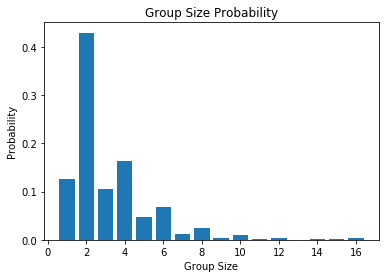

In [43]:
plt.bar(num_people, group_probabilities)
plt.title('Group Size Probability')
plt.xlabel('Group Size')
plt.ylabel('Probability')
plt.savefig('images/group_size_p.png')
plt.show();

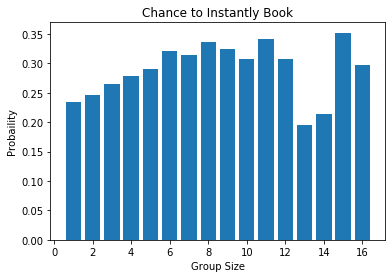

In [44]:
plt.bar(num_people,probability)
plt.title('Chance to Instantly Book')
plt.xlabel('Group Size')
plt.ylabel('Probaility')
plt.savefig('images/booking_chance.png')
plt.show();

Text(0.5, 0, 'Group Size')

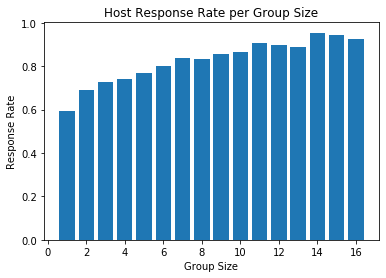

In [46]:
plt.bar(num_people, responses)
plt.title('Host Response Rate per Group Size')
plt.ylabel('Response Rate')
plt.xlabel('Group Size')

### Fix

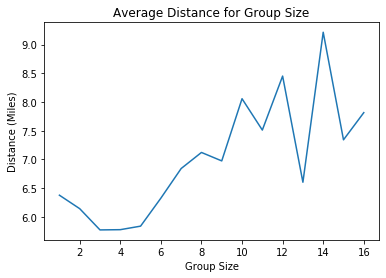

In [47]:
plt.plot(num_people,distances)
plt.title('Average Distance for Group Size')
plt.xlabel('Group Size')
plt.ylabel('Distance (Miles)')
plt.savefig('images/distance.png')
plt.show();

* Chicago info
* equal time on graphs

In [52]:
import import_ipynb
from work import chi_prices

ImportError: cannot import name 'chi_prices' from 'work' (work.ipynb)

In [54]:
chi_prices = [62.85652173913044,
             83.02415812591508,
             111.99675324675324,
             137.48458149779736,
             163.38425925925927,
             209.43304843304844,
             211.11320754716985,
             224.08130081300817,
             287.18181818181824,
             252.46153846153842,
             198.99999999999997,
             303.83333333333326,
             337.0000000000002,
             292.50000000000006,
             0.0,
             481.1111111111108]

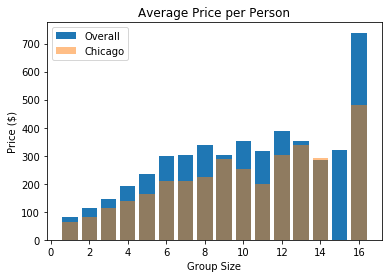

In [63]:
plt.bar(num_people,prices)
plt.bar(num_people,chi_prices,alpha=.5)
plt.title('Average Price per Person')
plt.xlabel('Group Size')
plt.ylabel('Price ($)')
plt.legend(['Overall', 'Chicago'])
plt.savefig('images/average_price.png')
plt.show();

In [69]:
chi_probability = [0.06470746832030197,
                   0.3817740630897816,
                   0.08627662442706929,
                   0.19034780264222162,
                   0.06093286600161769,
                   0.11081153949851712,
                   0.0159072526287409,
                   0.04259908331086546,
                   0.004044216770018873,
                   0.022377999460771097,
                   0.0010784578053383662,
                   0.0067403612833647885,
                   0.0018873011593421407,
                   0.0032353734160150984,
                   0.0010784578053383662,
                   0.006201132380695605]

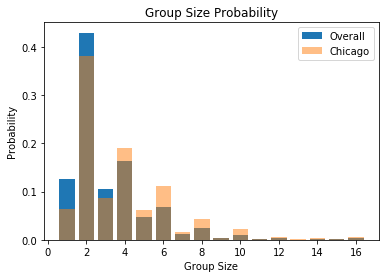

In [71]:
plt.bar(num_people, group_probabilities)
plt.bar(num_people, chi_probability, alpha=0.5)
plt.title('Group Size Probability')
plt.xlabel('Group Size')
plt.ylabel('Probability')
plt.legend(['Overall', 'Chicago'])
plt.savefig('images/group_size_p.png')
plt.show();

In [77]:
np.exp(5.25)

190.56626845863

In [78]:
np.mean(df_vis['log_price'])

150.43873576992212